1. Setup & Data Loading

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load the dataset
df = pd.read_csv('International_Education_Costs.csv')
print(f'Dataset shape: {df.shape}')
df.head()

Dataset shape: (907, 12)


,Country,City,University,Program,Level,Duration_Years,Tuition_USD,Living_Cost_Index,Rent_USD,Visa_Fee_USD,Insurance_USD,Exchange_Rate
0,USA,Cambridge,Harvard University,Computer Science,Master,2.0,55400,83.5,2200,160,1500,1.00
1,UK,London,Imperial College London,Data Science,Master,1.0,41200,75.8,1800,485,800,0.79
2,Canada,Toronto,University of Toronto,Business Analytics,Master,2.0,38500,72.5,1600,235,900,1.35
3,Australia,Melbourne,University of Melbourne,Engineering,Master,2.0,42000,71.2,1400,450,650,1.52
4,Germany,Munich,Technical University of Munich,Mechanical Engineering,Master,2.0,500,70.5,1100,75,550,0.92


2. Feature Engineering
- One-hot encode categoricals
- Scale numeric features
- Create affordability tiers (Low/Medium/High)
- Ensure TCA column exists

In [2]:
# Ensure TCA exists
if 'TCA' not in df.columns:
    try:
        df['TCA'] = df['Tuition_USD'] + df['Rent_USD'] * 12 + df['Visa_Fee_USD'] + df['Insurance_USD'] * 1
        print('TCA calculated and added.')
    except KeyError as e:
        print(f'Column not found: {e}')
        print('Please adjust column names for TCA calculation.')
else:
    print('TCA column already exists.')

TCA calculated and added.


In [3]:
# Create affordability tiers using TCA quantiles
df['Affordability_Tier'] = pd.qcut(df['TCA'], q=3, labels=['Low', 'Medium', 'High'])
df['Affordability_Tier'].value_counts()

Affordability_Tier
Low       303
High      303
Medium    301
Name: count, dtype: int64

In [4]:
# Identify categorical and numeric columns
categorical_cols = ['Country', 'City', 'Level', 'Program']
numeric_cols = ['Tuition_USD', 'Rent_USD', 'Visa_Fee_USD', 'Insurance_USD', 'Living_Cost_Index', 'Exchange_Rate']
# Remove columns not in df
categorical_cols = [col for col in categorical_cols if col in df.columns]
numeric_cols = [col for col in numeric_cols if col in df.columns]
print('Categorical columns:', categorical_cols)
print('Numeric columns:', numeric_cols)

Categorical columns: ['Country', 'City', 'Level', 'Program']
Numeric columns: ['Tuition_USD', 'Rent_USD', 'Visa_Fee_USD', 'Insurance_USD', 'Living_Cost_Index', 'Exchange_Rate']


3. Data Preparation for Modeling
- Split data into train/test
- Build preprocessing pipeline (encoding + scaling)

In [5]:
# Drop rows with missing TCA
df_model = df.dropna(subset=['TCA'])

X = df_model[categorical_cols + numeric_cols]
y = df_model['TCA']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)

print('Train shape:', X_train.shape)
print('Test shape:', X_test.shape)

Train shape: (725, 10)
Test shape: (182, 10)


4. Baseline Regression Model: Predicting TCA
- Linear Regression as baseline
- Evaluate with MAE, RMSE, R²

In [7]:
# Build pipeline
reg_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Train
reg_pipeline.fit(X_train, y_train)

# Predict
y_pred = reg_pipeline.predict(X_test)

# Evaluate
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f'MAE: {mae:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'R²: {r2:.2f}')

MAE: 0.24
RMSE: 0.47
R²: 1.00


5. Next Steps
Try more advanced models (XGBoost, LightGBM)
Build affordability classifier
Perform clustering
Hyperparameter tuning

1. XGBoost Regression for TCA
Install XGBoost if needed:

In [8]:
!pip install xgboost

In [9]:
from xgboost import XGBRegressor

# Build pipeline
xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(objective='reg:squarederror', random_state=42))
])

# Train
xgb_pipeline.fit(X_train, y_train)

# Predict
y_pred_xgb = xgb_pipeline.predict(X_test)

# Evaluate
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)
print(f'XGBoost MAE: {mae_xgb:.2f}')
print(f'XGBoost RMSE: {rmse_xgb:.2f}')
print(f'XGBoost R²: {r2_xgb:.2f}')

XGBoost MAE: 494.94
XGBoost RMSE: 705.84
XGBoost R²: 1.00


2. Affordability Classifier (Logistic Regression Example)

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report

# Prepare data
X_cls = df_model[categorical_cols + numeric_cols]
y_cls = df_model['Affordability_Tier']

X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(X_cls, y_cls, test_size=0.2, random_state=42)

cls_preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)

cls_pipeline = Pipeline([
    ('preprocessor', cls_preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, multi_class='multinomial'))
])

cls_pipeline.fit(X_train_cls, y_train_cls)
y_pred_cls = cls_pipeline.predict(X_test_cls)

print('Accuracy:', accuracy_score(y_test_cls, y_pred_cls))
print('Macro F1:', f1_score(y_test_cls, y_pred_cls, average='macro'))
print(classification_report(y_test_cls, y_pred_cls))

Accuracy: 0.9505494505494505
Macro F1: 0.9505683183183183
              precision    recall  f1-score   support

        High       0.94      1.00      0.97        62
         Low       0.95      0.96      0.95        55
      Medium       0.97      0.89      0.93        65

    accuracy                           0.95       182
   macro avg       0.95      0.95      0.95       182
weighted avg       0.95      0.95      0.95       182



/Users/chiti/Documents/GitHub/SDS-CP030-edu-spend/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


3. Clustering (KMeans Example)

In [13]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Use only numeric features for clustering
X_cluster = df_model[numeric_cols].dropna()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

df_model['Cluster'] = np.nan
df_model.loc[X_cluster.index, 'Cluster'] = clusters

print('Silhouette Score:', silhouette_score(X_scaled, clusters))
df_model['Cluster'].value_counts()

Silhouette Score: 0.405764927661971


Cluster
1.0    487
0.0    396
2.0     24
Name: count, dtype: int64

3.1. Visualize clusters

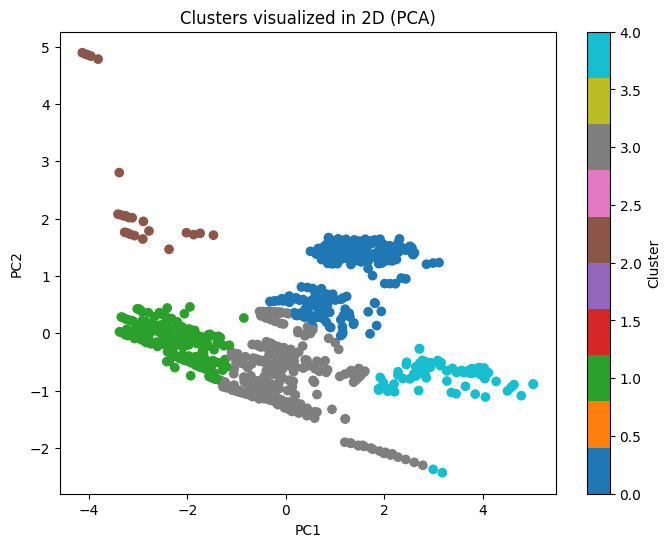

In [21]:
   from sklearn.decomposition import PCA
   import matplotlib.pyplot as plt

   pca = PCA(n_components=2)
   X_pca = pca.fit_transform(X_scaled)
   plt.figure(figsize=(8,6))
   plt.scatter(X_pca[:,0], X_pca[:,1], c=clusters, cmap='tab10')
   plt.title('Clusters visualized in 2D (PCA)')
   plt.xlabel('PC1')
   plt.ylabel('PC2')
   plt.colorbar(label='Cluster')
   plt.show()

4. Hyperparameter Tuning (GridSearchCV Example for XGBoost)

In [22]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'regressor__n_estimators': [50, 100],
    'regressor__max_depth': [3, 5, 7]
}

grid_search = GridSearchCV(
    xgb_pipeline,
    param_grid,
    cv=3,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)
print('Best params:', grid_search.best_params_)
print('Best MAE:', -grid_search.best_score_)

Best params: {'regressor__max_depth': 7, 'regressor__n_estimators': 100}
Best MAE: 606.5884399414062


Save The Best Model

In [26]:
import joblib

# If you used a pipeline (recommended)
joblib.dump(reg_pipeline, 'best_tca_model.joblib')

['best_tca_model.joblib']